In [1]:
import torch
import data_v3
import numpy as np
import os
import preprocess
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda = True
seed = 20190328
#dataDir = './data/wikitext-2'
words = 10000
temperature = 1.0
log_interval = 500

In [3]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [4]:
# Set the random seed manually for reproducibility.
torch.manual_seed(seed)
if torch.cuda.is_available():
    if not cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if cuda else "cpu")

In [5]:
# def getDataDir(model):
#     # returns data directory for the model
#     if model in ['cda.pt', 'CDA_and_lambda_0.5.pt','CDA_and_lambda_0.1.pt','CDA_and_lambda_0.8.pt']:
#         return '/home/urwa/Documents/Courses/NLU/GBLM/GBLM/Pytorch Model/CDA/wikitextCDA'
#     else:
#         return './data/wikitext-2'

In [6]:
def getParameters(model):
    # load vocab & file index  
    if 'cda' in model:
        path = 'processedDataCda/'
        vocab = preprocess.read_vocab(os.path.join('data','VOCAB_cda.txt'))
        idx_train = pd.read_json('data/idx_train_cda.json')
        idx_val = pd.read_json('data/idx_val_cda.json')
        idx_test = pd.read_json('data/idx_test_cda.json')
    else:
        path = 'processedData/'
        vocab = preprocess.read_vocab(os.path.join('data','VOCAB.txt'))
        idx_train = pd.read_json('data/idx_train.json')
        idx_val = pd.read_json('data/idx_val.json')
        idx_test = pd.read_json('data/idx_test.json')
            
    vocab.append('<eos>')
    words2idx = {item : index for index, item in enumerate(vocab)}
           
    return path, vocab, words2idx, idx_train, idx_val, idx_test

In [7]:
def getUpper(word):
    #print(word)
    word = word[0].upper() + word[1:]
    return word

In [8]:
# gender pair list taken from GN-Glove
DEFAULT_MALE_NOUNS = load_doc('gender_words/male_word_file.txt').split('\n')
DEFAULT_FEMALE_NOUNS = load_doc('gender_words/female_word_file.txt').split('\n')
DEFAULT_FEMALE_NOUNS += [getUpper(w) for w in DEFAULT_FEMALE_NOUNS if len(w)>0]
DEFAULT_MALE_NOUNS += [getUpper(w) for w in DEFAULT_MALE_NOUNS if len(w)>0]
len(DEFAULT_MALE_NOUNS)

447

In [9]:
occupations = load_doc('neutralOccupations.txt').split('\n')
occupations = [w for w in occupations if len(w)>0]
occupations += [getUpper(w) for w in occupations]
len(occupations)

80

In [10]:
def getGenderWords():
    pairs = [ (f,m) for f,m in zip(DEFAULT_FEMALE_NOUNS,DEFAULT_MALE_NOUNS) \
                 if f in corpus.words2idx and m in corpus.words2idx]
    femaleWords = [ f for f,m in pairs]
    maleWords = [ m for f,m in pairs]
    print('gender pairs: ',len(maleWords))
    return femaleWords,maleWords

In [11]:
def getSentencePairs(template):
    sentencePairs = []
    for i in range(len(femaleWords)):
        pair = {'f':femaleWords[i]+template, 'm':maleWords[i]+template}
        sentencePairs.append(pair)
    #for i in range(len(femaleWords)):
    #    pair = {'f':'The ' + femaleWords[i]+template, 'm':'The ' + maleWords[i]+template}
    #    sentencePairs.append(pair)
    return sentencePairs

In [12]:
def getIdx(pair):
    sentence1 = pair['m']
    sentence2 = pair['f']
    tok1 = sentence1.split()
    idx1 = torch.LongTensor([[corpus.words2idx[t] for t in tok1]]).t().to(device)

    tok2 = sentence2.split()
    idx2 = torch.LongTensor([[corpus.words2idx[t] for t in tok2]]).t().to(device)
    return idx1,idx2

In [13]:
def getBias(model, idx1, idx2):  
    hidden = model.init_hidden(1)
    output, hidden = model(idx1, hidden)
    dist1 = output[len(idx1)-1][0]
    occ1 = [dist1[i].item() for i in occIdx]
    
    hidden = model.init_hidden(1)
    output, hidden = model(idx2, hidden)
    dist2 = output[len(idx2)-1][0]
    occ2 = [dist2[i].item() for i in occIdx]
    
    biasMod = np.sum(np.abs(np.array(occ1)-np.array(occ2)))
    bias = np.sum(np.array(occ1)-np.array(occ2))
    occDist = dict(zip([corpus.idx2words[o] for o in occIdx],np.array(occ1)-np.array(occ2)))
    return bias,biasMod,occDist

In [14]:
def getTotBias(checkpoint):
    with open(checkpoint, 'rb') as f:
        model = torch.load(f).to(device)
    model.eval()
    biasA = []
    biasD = []
    biasDist = []
    for p in sentencePairs:
        idx1,idx2 = getIdx(p)
        D,A,dist = getBias(model, idx1, idx2)
        biasA.append(A)
        biasD.append(D)
        biasDist.append(dist)
    return sum(biasD)/len(biasD),sum(biasA)/len(biasA),biasDist

In [15]:
templates = [' is a', ' worked as a']

In [16]:
modelDir = './models/'
modelFiles = [m for m in os.listdir(modelDir) if m.endswith('.pt')]
modelFiles

['reg_0.5.pt',
 'lambda_1_cda.pt',
 'lambda_0.1.pt',
 'lambda_0.5.pt',
 'lambda_0.8.pt',
 'lambda_1.pt',
 'lambda_0.8_cda.pt',
 'cda.pt',
 'lambda_5.pt',
 'lambda_0.1_cda.pt',
 'lambda_10.pt',
 'reg_0.1.pt',
 'lambda_0.01.pt',
 'lambda_8.pt',
 'lambda_2.pt',
 'lambda_0_baseline.pt',
 'reg_0.8.pt',
 'lambda_0.5_cda.pt',
 'glove.pt']

In [17]:
#models = ['model_cda_0','model_cda_0.5','model_cda_2']

In [20]:
biasList = []
for m in modelFiles:
    
    print('processing:',m)
    
    path, vocab, words2idx, idx_train, idx_val, idx_test = getParameters(m)
    corpus = data_v3.Corpus(path, vocab, words2idx, idx_train, idx_val, idx_test)
    ntokens = len(vocab)
    
    femaleWords,maleWords = getGenderWords()
    
    sentencePairs = []
    for t in templates:
        sentencePairs += getSentencePairs(t)
    print('templates: ',len(sentencePairs))
    
    occIdx = [corpus.words2idx[o] for o in occupations if o in corpus.words2idx]
    print('occupations: ',len(occIdx))
    
    checkpoint = modelDir+m
    b = getTotBias(checkpoint)
    biasList.append(b)
    print(b[0],b[1])

processing: reg_0.5.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.05850414132582955 13.709327725319115
processing: lambda_1_cda.pt
gender pairs:  166
templates:  332
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.041612729654613746 0.04648301445217018
processing: lambda_0.1.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.06962653376782933 0.5270780326488117
processing: lambda_0.5.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.15111367735080422 0.25103663564659656
processing: lambda_0.8.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.02218232029117644 0.24139559174266953
processing: lambda_1.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.05296117227214078 0.21691608297017714
processing: lambda_0.8_cda.pt
gender pairs:  166
templates:  332
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.01702287914343627 0.035092525475894115
processing: cda.pt
gender pairs:  166
templates:  332
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.7959969966077661 10.094379927076579
processing: lambda_5.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.04218316935002804 0.08843876011669635
processing: lambda_0.1_cda.pt
gender pairs:  166
templates:  332
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.037746987900281526 0.050552955839827836
processing: lambda_10.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.01269959054576854 0.07213838847043613
processing: reg_0.1.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.17498272894493613 12.777627367685394
processing: lambda_0.01.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.02656177987034122 1.6923669842071831
processing: lambda_8.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.010218986372152964 0.09497290949026743
processing: lambda_2.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.008861496842776736 0.10398128891053299
processing: lambda_0_baseline.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.4174180369824171 17.580589184165
processing: reg_0.8.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.0716595375231312 17.78606683043569
processing: lambda_0.5_cda.pt
gender pairs:  166
templates:  332
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.009474837569048605 0.033293087775987315
processing: glove.pt
gender pairs:  120
templates:  240
occupations:  35


/home/urwa/miniconda3/envs/NLUnew/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


-0.41294007310643793 17.5762587598525


In [25]:
modelNames = ['.'.join(m.split('.')[:-1]) for m in modelFiles]
modelNames

['lambda_0.1',
 'lambda_0.5',
 'lambda_0.8',
 'lambda_1',
 'lambda_5',
 'lambda_0.01',
 'lambda_0',
 'lambda_2']

In [26]:
biasMod = [b[1] for b in biasList]
biasAvg = [b[0] for b in biasList]
biasDist = [b[2] for b in biasList]

In [28]:
## Just arranging model names by lambda
mm = ['lambda_0','lambda_0.01','lambda_0.1','lambda_0.5','lambda_0.8','lambda_1','lambda_2','lambda_5']
biasMod = [dict(zip(modelNames,biasMod))[m] for m in mm]
biasAvg = [dict(zip(modelNames,biasAvg))[m] for m in mm]
biasDist = [dict(zip(modelNames,biasDist))[m] for m in mm]
modelsNames = mm

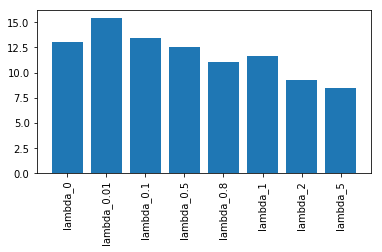

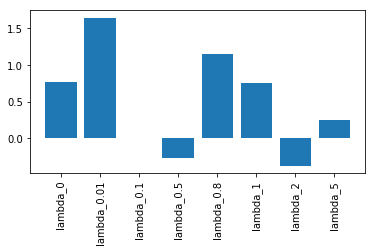

In [29]:
plt.figure(figsize=(6,3))
plt.bar(modelsNames, biasMod)
_=plt.xticks(modelsNames, rotation='vertical')

plt.figure(figsize=(6,3))
plt.bar(modelsNames, biasAvg)
_=plt.xticks(modelsNames, rotation='vertical')

In [30]:
biasDict = []
for i in range(len(modelsNames)):
    bDist = biasDist[i] #list
    bdict = {}
    countDict = {}
    for bd in bDist:
        for b in bd:
            if b in bdict:
                countDict[b] += 1
                bdict[b] += bd[b]
            else:
                bdict[b] = bd[b]
                countDict[b] = 1
    
    for b in bdict:
        bdict[b] /= countDict[b]
    biasDict.append(bdict)

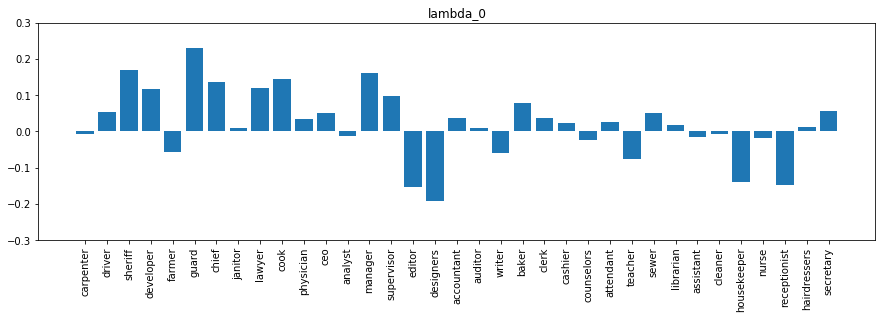

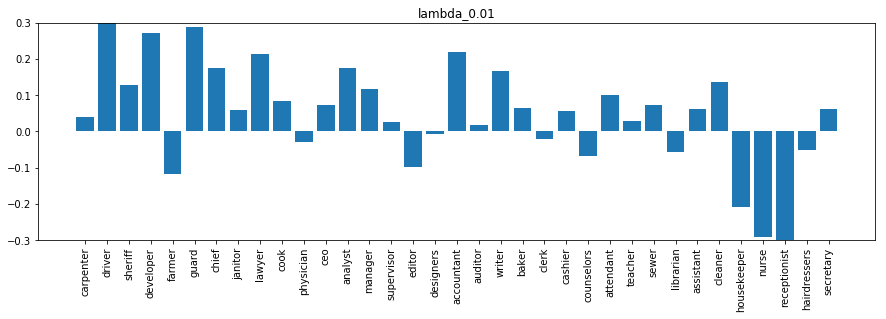

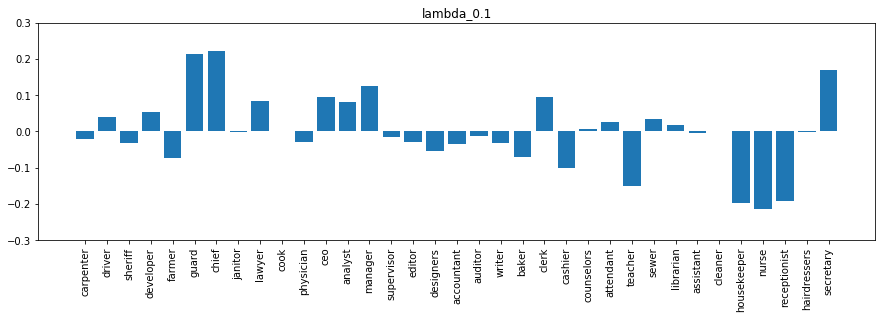

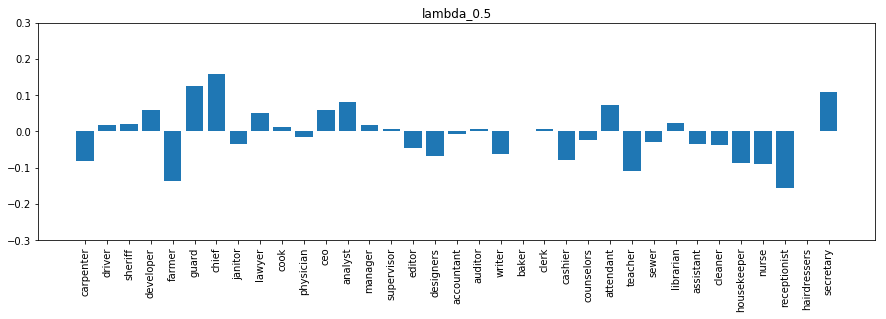

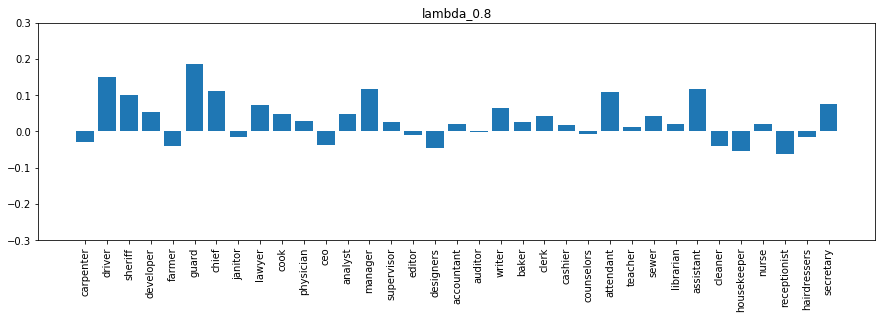

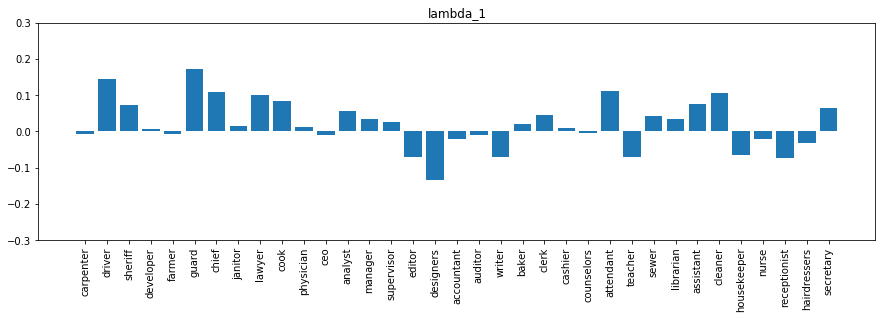

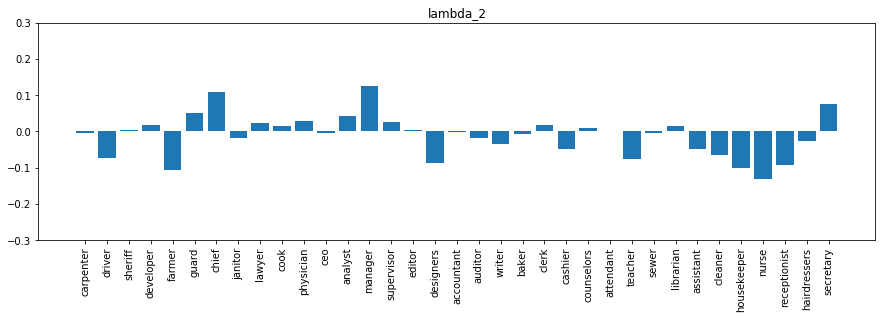

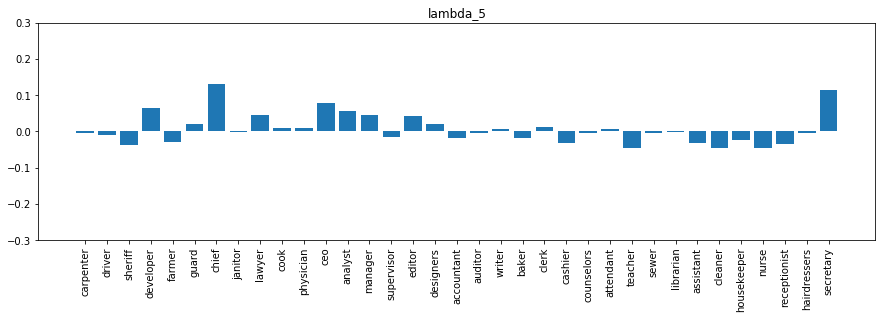

In [33]:
#biasDist
for i in range(len(modelsNames)):
    bdict = biasDict[i]
    plt.figure(figsize=(15,4))
    plt.bar(list(bdict.keys()), list(bdict.values()))
    plt.title(modelsNames[i])
    plt.ylim((-0.3,0.3))
    _=plt.xticks(list(bdict.keys()), rotation='vertical')

In [26]:
print(torch.__version__)

0.4.1.post2
